# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки
* **DateCrawled** — дата скачивания анкеты из базы
* **VehicleType** — тип автомобильного кузова
* **RegistrationYear** — год регистрации автомобиля
* **Gearbox** — тип коробки передач
* **Power** — мощность (л. с.)
* **Model** — модель автомобиля
* **Kilometer** — пробег (км)
* **RegistrationMonth** — месяц регистрации автомобиля
* **FuelType** — тип топлива
* **Brand** — марка автомобиля
* **Repaired** — была машина в ремонте или нет
* **DateCreated** — дата создания анкеты
* **NumberOfPictures** — количество фотографий автомобиля
* **PostalCode** — почтовый индекс владельца анкеты (пользователя)
* **LastSeen** — дата последней активности пользователя

Целевой признак
* **Price** — цена (евро)

## Подготовка данных

In [1]:
!pip3 install catboost
!pip3 install lightgbm


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder
import time


RANDOM = 42

In [2]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('autos.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
(df
    .isna()
    .sum()
    .sort_values(ascending = False))

Repaired             71154
VehicleType          37490
FuelType             32895
Gearbox              19833
Model                19705
DateCrawled              0
Price                    0
RegistrationYear         0
Power                    0
Kilometer                0
RegistrationMonth        0
Brand                    0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

<AxesSubplot:>

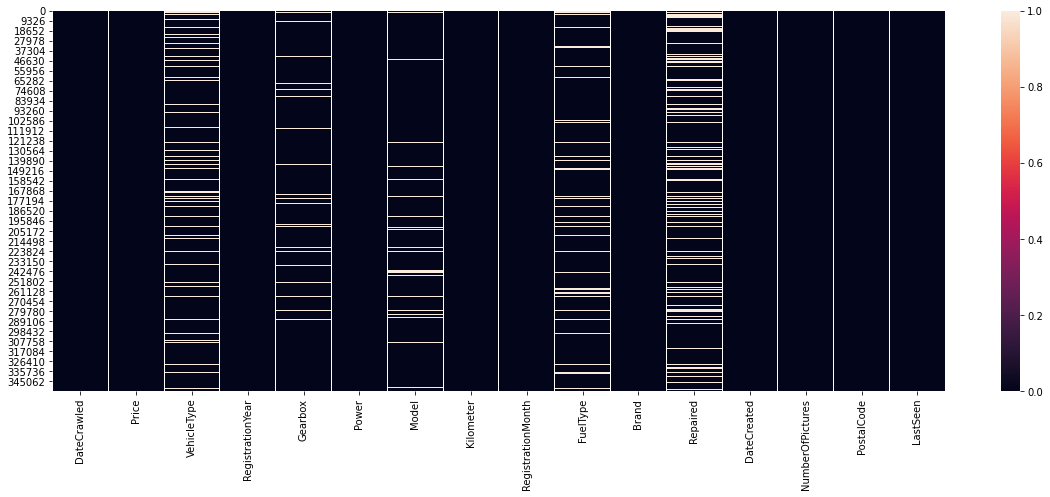

In [7]:
#Визаулизируем пропуски
plt.figure(figsize = (20,7))
sns.heatmap(df[df.columns].isnull())

Пропуски в данных присутствуют только в категориальных переменных. Те, кто продают автомобили, часто не указывают была ли машина в ремонте - **`Repaired`**, тип топлива **`FuelType`**, модель автомобиля **`Model`**, тип коробки передач **`Gearbox`** и тип кузова **`VehicleType`**.
Поскольку пропусков много, то удаление всех строк, содержащих их, снесет ощутимую часть данных. Восстановить данные по косвенных признакам не удастся, единственным корректным решением кажется заполнение пропусков нулями. Однако я попробую заполнить пропуски модой в признаках **`FuelType`**, **`Gearbox`** и **`Repaired`**, поскольку уникальных признаков в этих переменных не так много, и один из признаков встречается явно чаще, чем остальные. В остальных переменных пропуски заполним нулями.

In [3]:
df['FuelType'] = df['FuelType'].fillna(df['FuelType'].mode()[0])
df['Gearbox'] = df['Gearbox'].fillna(df['Gearbox'].mode()[0])
df['Repaired'] = df['Repaired'].fillna(df['Repaired'].mode()[0])
df = df.fillna(0)

In [4]:
#Проверим наличие дубликатов
df.duplicated().sum()

5

In [5]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [6]:
#Уберем колонки, которые не влияют на стоимость автомобиля
df = df.drop(["DateCrawled","DateCreated","LastSeen","NumberOfPictures","PostalCode", "RegistrationMonth"], axis = 1)

### Очистка данных от аномалий

Text(0.5, 1.0, 'Пробег')

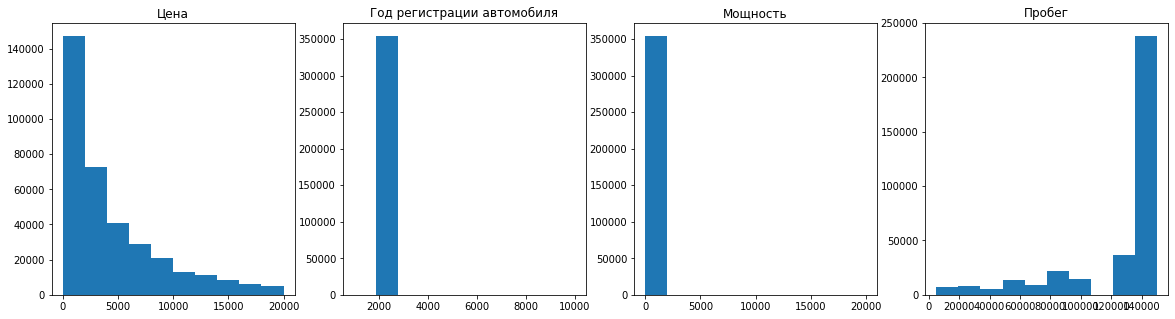

In [56]:
#Помсотрим на распределение на численных переменных
fig, axs = plt.subplots(1, 4, figsize=(20,5))

axs[0].hist(df['Price'])
axs[0].set_title('Цена')

axs[1].hist(df['RegistrationYear'])
axs[1].set_title('Год регистрации автомобиля')

axs[2].hist(df['Power'])
axs[2].set_title('Мощность')

axs[3].hist(df['Kilometer'])
axs[3].set_title("Пробег")



* **`Price`** - Будем считать аномалиями то, что выходит за пределы 1,5 межквартильного размаха.
* **`RegistrationYear`** - В даных о годе регистрации автомобиля встречаются явно не корректные значения. Отбросим значения, не входящие в промежуток межу 1930 и 2016 годом.
* **`Power`** - В данны о мощности также есть аномалии. Ограничимся можностью в диапазоне 10 - 500 л.с.
* **`Kilometer`** - В данных о пробегах заметных ывбросов нет. Могут встречаться как маленькие так и большие пробеги. Верхняя граница пробега выглядит достаточно реальной. Оставляем колонку как есть.

In [7]:
len_before = len(df)

In [8]:
def get_clean_data(col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    df_clean = df.loc[(df[col]  < q3 + 1.5*iqr) & (df[col]  > q1 - 1.5*iqr)]
    return df_clean

In [9]:
df = get_clean_data('Price')
df = df.loc[(df['RegistrationYear'] >= 1930) & (df['RegistrationYear'] <= 2016), :]
df = df.loc[(df['Power'] >= 10) & (df['Power'] <= 500), :]

print(f'Изначальная длинна датасета {len_before}, в ходе чистки данных от аномалий удалено {len_before- len(df)} строк')

Изначальная длинна датасета 354364, в ходе чистки данных от аномалий удалено 69784 строк


### Выводы по предобработке данных.
* Из данных отбросили колонки, которые не влияют на стоимость автомобиля.

* Пропуски в категориальных признаках заменены на моду в тех колнках, где уникальных значений не так много и наблюдается явный "перекос" в сторону одного из признаков. В остальных колонках пропуски заменены на нули.

* Аномальные значения в колонке **`Price`** отброшены, если не попадают в диапазон +-1,5 межквартильных размахов. 

* Из колонки **`RegistrationYear`** взяты только строки, где год регистрации попадает в диапазон 1930 - 2016 год. 

* Из колонки **`Power`** взяты только автомобили, с мощностью двигателя 10 - 500 л.с.

* Суммарно из данных отброшено 69784 строк, т.е. почти 20%. Это достаточно большой объем, однако выбросы помешали бы модели корректно обучаться.


## Обучение моделей

In [10]:
#Датасет для LightGBM
df_lightgbm= df.astype({"VehicleType":'category',
                      "Gearbox":'category',
                      "Model":'category',
                      "FuelType":'category',
                      "Brand":'category',
                      "Repaired":'category'})
df_lightgbm.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


In [11]:
#Разделим данные на тренировочные и тестовые выброки
#Для оригинального датасета
features_train, features_test, target_train, target_test = train_test_split(df.drop("Price",axis = 1),
                                                                            df['Price'],
                                                                            test_size=0.25,
                                                                            random_state=RANDOM)

#Для датасета под LightGBM
features_train_light, features_test_light, target_train_light, target_test_light = train_test_split(df_lightgbm.drop("Price",axis = 1),
                                                                                                    df_lightgbm['Price'],
                                                                                                    test_size=0.25,
                                                                                                    random_state=RANDOM)

In [12]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
#тк у нас в пропусках нули, то поставим костыль))): 
features_train[cat_columns] = features_train[cat_columns].astype('str')

encoder.fit(features_train[cat_columns])

features_train_ord = features_train.copy()
features_test_ord = features_test.copy()

features_train_ord[cat_columns] = encoder.transform(features_train_ord[cat_columns])
features_test_ord[cat_columns] = encoder.transform(features_test_ord[cat_columns])

```python
# порядковое кодирование
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
cat_columns = [список всех категориальных признаков]
encoder.fit(features_train[cat_columns])

features_train_ord = features_train.copy()
features_valid_ord = features_valid.copy()
features_test_ord = features_test.copy()

features_train_ord[cat_columns] = encoder.transform(features_train_ord[cat_columns])
features_valid_ord[cat_columns] = encoder.transform(features_valid_ord[cat_columns])
features_test_ord[cat_columns] = encoder.transform(features_test_ord[cat_columns])
```

In [ ]:
%%time
#Для поиска оптимальных гиперпараметров для градиентного бустинга, воспользуемся gridsearch

catboost = CatBoostRegressor(loss_function='RMSE')

params_cat = {'depth':np.arange(1,10,2), 
              'learning_rate':np.arange(0.1,1,0.2)}

catboost_grid = catboost.grid_search(params_cat,
            Pool(features_train, target_train, cat_features=["VehicleType",
                                                             "Gearbox",
                                                             "Model",
                                                             "FuelType",
                                                             "Brand",
                                                             "Repaired"]),
            cv=3,
            verbose=True)

In [15]:
#Проверим лучшие параметры
catboost_grid["params"]

NameError: name 'catboost_grid' is not defined

In [16]:
%%time
#Обучим модель и сохраним время
meow = CatBoostRegressor(depth=10,
                         learning_rate=0.1,
                         loss_function='RMSE',
                         verbose=100)
start = time.time()
meow.fit(Pool(features_train, target_train,
              cat_features=["VehicleType",
                            "Gearbox","Model",
                            "FuelType","Brand",
                            "Repaired"]))
stop= time.time()
training_time_cat = stop - start

0:	learn: 3298.0806900	total: 848ms	remaining: 14m 7s
100:	learn: 1420.0206155	total: 1m 33s	remaining: 13m 56s
200:	learn: 1361.8315611	total: 3m 13s	remaining: 12m 48s
300:	learn: 1328.0030684	total: 5m 6s	remaining: 11m 52s
400:	learn: 1301.5137580	total: 6m 55s	remaining: 10m 20s
500:	learn: 1281.8542414	total: 8m 19s	remaining: 8m 17s
600:	learn: 1263.7944325	total: 9m 41s	remaining: 6m 26s
700:	learn: 1249.2794416	total: 11m 5s	remaining: 4m 43s
800:	learn: 1236.0913809	total: 12m 28s	remaining: 3m 5s
900:	learn: 1222.8256320	total: 13m 50s	remaining: 1m 31s
999:	learn: 1213.2992100	total: 15m 17s	remaining: 0us
CPU times: total: 26min 5s
Wall time: 15min 23s


In [ ]:
#Проверим качество моели на кросс-валидации
params = {
    'loss_function': 'RMSE',
    'depth': 10,
    'learning_rate': 0.1
}

scores = cv(Pool(features_train, target_train, cat_features=["VehicleType",
                                                          "Gearbox","Model",
                                                          "FuelType","Brand",
                                                          "Repaired"]),
            params,
            fold_count=5)

best_score = scores['test-RMSE-mean'].min()

In [ ]:
print(f'RMSE модели catboost - {best_score}.')
#Качество модели удослетворяет условию задания

In [17]:
%%time
#RandomForest
rf = RandomForestRegressor(criterion = "squared_error", random_state=RANDOM)

rf_params = { 'n_estimators': range (1, 15, 2),
              'max_depth': range (1,15, 2) }

rf_grid_final = GridSearchCV(rf, rf_params, scoring='neg_mean_squared_error', verbose=10 )
rf_grid_final.fit(features_train_ord, target_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits
[CV 1/5; 1/49] START max_depth=1, n_estimators=1................................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 1/5; 1/49] END max_depth=1, n_estimators=1;, score=-8027012.359 total time=   0.1s
[CV 2/5; 1/49] START max_depth=1, n_estimators=1................................
[CV 2/5; 1/49] END max_depth=1, n_estimators=1;, score=-8021162.146 total time=   0.0s
[CV 3/5; 1/49] START max_depth=1, n_estimators=1................................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 3/5; 1/49] END max_depth=1, n_estimators=1;, score=-8065734.093 total time=   0.0s
[CV 4/5; 1/49] START max_depth=1, n_estimators=1................................
[CV 4/5; 1/49] END max_depth=1, n_estimators=1;, score=-8015316.372 total time=   0.0s
[CV 5/5; 1/49] START max_depth=1, n_estimators=1................................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 5/5; 1/49] END max_depth=1, n_estimators=1;, score=-8054367.335 total time=   0.0s
[CV 1/5; 2/49] START max_depth=1, n_estimators=3................................
[CV 1/5; 2/49] END max_depth=1, n_estimators=3;, score=-8027012.089 total time=   0.2s
[CV 2/5; 2/49] START max_depth=1, n_estimators=3................................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 2/5; 2/49] END max_depth=1, n_estimators=3;, score=-8021045.794 total time=   0.3s
[CV 3/5; 2/49] START max_depth=1, n_estimators=3................................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 3/5; 2/49] END max_depth=1, n_estimators=3;, score=-8065688.560 total time=   0.2s
[CV 4/5; 2/49] START max_depth=1, n_estimators=3................................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 4/5; 2/49] END max_depth=1, n_estimators=3;, score=-8015034.420 total time=   0.2s
[CV 5/5; 2/49] START max_depth=1, n_estimators=3................................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 5/5; 2/49] END max_depth=1, n_estimators=3;, score=-8054676.576 total time=   0.3s
[CV 1/5; 3/49] START max_depth=1, n_estimators=5................................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 1/5; 3/49] END max_depth=1, n_estimators=5;, score=-8027035.727 total time=   0.4s
[CV 2/5; 3/49] START max_depth=1, n_estimators=5................................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 2/5; 3/49] END max_depth=1, n_estimators=5;, score=-8020721.486 total time=   0.4s
[CV 3/5; 3/49] START max_depth=1, n_estimators=5................................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 3/5; 3/49] END max_depth=1, n_estimators=5;, score=-8065768.807 total time=   0.4s
[CV 4/5; 3/49] START max_depth=1, n_estimators=5................................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 4/5; 3/49] END max_depth=1, n_estimators=5;, score=-8015073.964 total time=   0.5s
[CV 5/5; 3/49] START max_depth=1, n_estimators=5................................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 5/5; 3/49] END max_depth=1, n_estimators=5;, score=-8054722.304 total time=   0.4s
[CV 1/5; 4/49] START max_depth=1, n_estimators=7................................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 1/5; 4/49] END max_depth=1, n_estimators=7;, score=-8027011.221 total time=   0.5s
[CV 2/5; 4/49] START max_depth=1, n_estimators=7................................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 2/5; 4/49] END max_depth=1, n_estimators=7;, score=-8020891.976 total time=   0.5s
[CV 3/5; 4/49] START max_depth=1, n_estimators=7................................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 3/5; 4/49] END max_depth=1, n_estimators=7;, score=-8065767.964 total time=   0.5s
[CV 4/5; 4/49] START max_depth=1, n_estimators=7................................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 4/5; 4/49] END max_depth=1, n_estimators=7;, score=-8015127.695 total time=   0.5s
[CV 5/5; 4/49] START max_depth=1, n_estimators=7................................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 5/5; 4/49] END max_depth=1, n_estimators=7;, score=-8054590.919 total time=   0.7s
[CV 1/5; 5/49] START max_depth=1, n_estimators=9................................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 1/5; 5/49] END max_depth=1, n_estimators=9;, score=-8027015.145 total time=   0.8s
[CV 2/5; 5/49] START max_depth=1, n_estimators=9................................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 2/5; 5/49] END max_depth=1, n_estimators=9;, score=-8020719.775 total time=   1.0s
[CV 3/5; 5/49] START max_depth=1, n_estimators=9................................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 3/5; 5/49] END max_depth=1, n_estimators=9;, score=-8065813.487 total time=   0.6s
[CV 4/5; 5/49] START max_depth=1, n_estimators=9................................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 4/5; 5/49] END max_depth=1, n_estimators=9;, score=-8015228.705 total time=   0.6s
[CV 5/5; 5/49] START max_depth=1, n_estimators=9................................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 5/5; 5/49] END max_depth=1, n_estimators=9;, score=-8054512.747 total time=   0.7s
[CV 1/5; 6/49] START max_depth=1, n_estimators=11...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 1/5; 6/49] END max_depth=1, n_estimators=11;, score=-8027023.210 total time=   0.8s
[CV 2/5; 6/49] START max_depth=1, n_estimators=11...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 2/5; 6/49] END max_depth=1, n_estimators=11;, score=-8020659.762 total time=   0.9s
[CV 3/5; 6/49] START max_depth=1, n_estimators=11...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 3/5; 6/49] END max_depth=1, n_estimators=11;, score=-8065839.130 total time=   0.8s
[CV 4/5; 6/49] START max_depth=1, n_estimators=11...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 4/5; 6/49] END max_depth=1, n_estimators=11;, score=-8015278.058 total time=   0.8s
[CV 5/5; 6/49] START max_depth=1, n_estimators=11...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 5/5; 6/49] END max_depth=1, n_estimators=11;, score=-8054512.876 total time=   0.8s
[CV 1/5; 7/49] START max_depth=1, n_estimators=13...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 1/5; 7/49] END max_depth=1, n_estimators=13;, score=-8027024.213 total time=   1.0s
[CV 2/5; 7/49] START max_depth=1, n_estimators=13...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 2/5; 7/49] END max_depth=1, n_estimators=13;, score=-8020684.056 total time=   1.0s
[CV 3/5; 7/49] START max_depth=1, n_estimators=13...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 3/5; 7/49] END max_depth=1, n_estimators=13;, score=-8065825.128 total time=   0.9s
[CV 4/5; 7/49] START max_depth=1, n_estimators=13...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 4/5; 7/49] END max_depth=1, n_estimators=13;, score=-8015319.264 total time=   1.0s
[CV 5/5; 7/49] START max_depth=1, n_estimators=13...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 5/5; 7/49] END max_depth=1, n_estimators=13;, score=-8054515.023 total time=   1.0s
[CV 1/5; 8/49] START max_depth=3, n_estimators=1................................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 1/5; 8/49] END max_depth=3, n_estimators=1;, score=-5635982.778 total time=   0.1s
[CV 2/5; 8/49] START max_depth=3, n_estimators=1................................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 2/5; 8/49] END max_depth=3, n_estimators=1;, score=-5548520.060 total time=   0.2s
[CV 3/5; 8/49] START max_depth=3, n_estimators=1................................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 3/5; 8/49] END max_depth=3, n_estimators=1;, score=-5596841.469 total time=   0.2s
[CV 4/5; 8/49] START max_depth=3, n_estimators=1................................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 4/5; 8/49] END max_depth=3, n_estimators=1;, score=-5594420.290 total time=   0.2s
[CV 5/5; 8/49] START max_depth=3, n_estimators=1................................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 5/5; 8/49] END max_depth=3, n_estimators=1;, score=-5612209.165 total time=   0.2s
[CV 1/5; 9/49] START max_depth=3, n_estimators=3................................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 1/5; 9/49] END max_depth=3, n_estimators=3;, score=-5619520.473 total time=   0.5s
[CV 2/5; 9/49] START max_depth=3, n_estimators=3................................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 2/5; 9/49] END max_depth=3, n_estimators=3;, score=-5546561.051 total time=   0.5s
[CV 3/5; 9/49] START max_depth=3, n_estimators=3................................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 3/5; 9/49] END max_depth=3, n_estimators=3;, score=-5581441.812 total time=   0.5s
[CV 4/5; 9/49] START max_depth=3, n_estimators=3................................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 4/5; 9/49] END max_depth=3, n_estimators=3;, score=-5594830.749 total time=   0.5s
[CV 5/5; 9/49] START max_depth=3, n_estimators=3................................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 5/5; 9/49] END max_depth=3, n_estimators=3;, score=-5599694.967 total time=   0.5s
[CV 1/5; 10/49] START max_depth=3, n_estimators=5...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 1/5; 10/49] END max_depth=3, n_estimators=5;, score=-5618597.361 total time=   0.9s
[CV 2/5; 10/49] START max_depth=3, n_estimators=5...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 2/5; 10/49] END max_depth=3, n_estimators=5;, score=-5545842.024 total time=   0.9s
[CV 3/5; 10/49] START max_depth=3, n_estimators=5...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 3/5; 10/49] END max_depth=3, n_estimators=5;, score=-5580163.730 total time=   1.0s
[CV 4/5; 10/49] START max_depth=3, n_estimators=5...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 4/5; 10/49] END max_depth=3, n_estimators=5;, score=-5594625.915 total time=   1.0s
[CV 5/5; 10/49] START max_depth=3, n_estimators=5...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 5/5; 10/49] END max_depth=3, n_estimators=5;, score=-5565032.992 total time=   1.1s
[CV 1/5; 11/49] START max_depth=3, n_estimators=7...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 1/5; 11/49] END max_depth=3, n_estimators=7;, score=-5619814.351 total time=   1.4s
[CV 2/5; 11/49] START max_depth=3, n_estimators=7...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 2/5; 11/49] END max_depth=3, n_estimators=7;, score=-5546172.373 total time=   1.4s
[CV 3/5; 11/49] START max_depth=3, n_estimators=7...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 3/5; 11/49] END max_depth=3, n_estimators=7;, score=-5579762.690 total time=   1.4s
[CV 4/5; 11/49] START max_depth=3, n_estimators=7...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 4/5; 11/49] END max_depth=3, n_estimators=7;, score=-5594542.181 total time=   1.4s
[CV 5/5; 11/49] START max_depth=3, n_estimators=7...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 5/5; 11/49] END max_depth=3, n_estimators=7;, score=-5573638.702 total time=   1.6s
[CV 1/5; 12/49] START max_depth=3, n_estimators=9...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 1/5; 12/49] END max_depth=3, n_estimators=9;, score=-5621474.464 total time=   1.8s
[CV 2/5; 12/49] START max_depth=3, n_estimators=9...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 2/5; 12/49] END max_depth=3, n_estimators=9;, score=-5545914.080 total time=   1.7s
[CV 3/5; 12/49] START max_depth=3, n_estimators=9...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 3/5; 12/49] END max_depth=3, n_estimators=9;, score=-5580948.574 total time=   1.6s
[CV 4/5; 12/49] START max_depth=3, n_estimators=9...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 4/5; 12/49] END max_depth=3, n_estimators=9;, score=-5594484.022 total time=   1.7s
[CV 5/5; 12/49] START max_depth=3, n_estimators=9...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 5/5; 12/49] END max_depth=3, n_estimators=9;, score=-5578148.063 total time=   1.6s
[CV 1/5; 13/49] START max_depth=3, n_estimators=11..............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 1/5; 13/49] END max_depth=3, n_estimators=11;, score=-5622847.265 total time=   2.1s
[CV 2/5; 13/49] START max_depth=3, n_estimators=11..............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 2/5; 13/49] END max_depth=3, n_estimators=11;, score=-5545536.848 total time=   2.0s
[CV 3/5; 13/49] START max_depth=3, n_estimators=11..............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 3/5; 13/49] END max_depth=3, n_estimators=11;, score=-5582260.110 total time=   2.0s
[CV 4/5; 13/49] START max_depth=3, n_estimators=11..............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 4/5; 13/49] END max_depth=3, n_estimators=11;, score=-5594579.401 total time=   2.0s
[CV 5/5; 13/49] START max_depth=3, n_estimators=11..............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 5/5; 13/49] END max_depth=3, n_estimators=11;, score=-5578466.130 total time=   2.0s
[CV 1/5; 14/49] START max_depth=3, n_estimators=13..............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 1/5; 14/49] END max_depth=3, n_estimators=13;, score=-5623761.398 total time=   2.4s
[CV 2/5; 14/49] START max_depth=3, n_estimators=13..............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 2/5; 14/49] END max_depth=3, n_estimators=13;, score=-5545572.062 total time=   2.4s
[CV 3/5; 14/49] START max_depth=3, n_estimators=13..............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 3/5; 14/49] END max_depth=3, n_estimators=13;, score=-5583440.504 total time=   2.4s
[CV 4/5; 14/49] START max_depth=3, n_estimators=13..............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 4/5; 14/49] END max_depth=3, n_estimators=13;, score=-5594640.371 total time=   2.4s
[CV 5/5; 14/49] START max_depth=3, n_estimators=13..............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 5/5; 14/49] END max_depth=3, n_estimators=13;, score=-5579853.571 total time=   2.4s
[CV 1/5; 15/49] START max_depth=5, n_estimators=1...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 1/5; 15/49] END max_depth=5, n_estimators=1;, score=-4133887.893 total time=   0.3s
[CV 2/5; 15/49] START max_depth=5, n_estimators=1...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 2/5; 15/49] END max_depth=5, n_estimators=1;, score=-4035446.978 total time=   0.3s
[CV 3/5; 15/49] START max_depth=5, n_estimators=1...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 3/5; 15/49] END max_depth=5, n_estimators=1;, score=-4077811.119 total time=   0.3s
[CV 4/5; 15/49] START max_depth=5, n_estimators=1...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 4/5; 15/49] END max_depth=5, n_estimators=1;, score=-4022398.963 total time=   0.3s
[CV 5/5; 15/49] START max_depth=5, n_estimators=1...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 5/5; 15/49] END max_depth=5, n_estimators=1;, score=-4055706.467 total time=   0.3s
[CV 1/5; 16/49] START max_depth=5, n_estimators=3...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 1/5; 16/49] END max_depth=5, n_estimators=3;, score=-4079228.073 total time=   0.8s
[CV 2/5; 16/49] START max_depth=5, n_estimators=3...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 2/5; 16/49] END max_depth=5, n_estimators=3;, score=-3997029.879 total time=   0.9s
[CV 3/5; 16/49] START max_depth=5, n_estimators=3...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 3/5; 16/49] END max_depth=5, n_estimators=3;, score=-4038861.061 total time=   0.8s
[CV 4/5; 16/49] START max_depth=5, n_estimators=3...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 4/5; 16/49] END max_depth=5, n_estimators=3;, score=-3991737.380 total time=   0.9s
[CV 5/5; 16/49] START max_depth=5, n_estimators=3...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 5/5; 16/49] END max_depth=5, n_estimators=3;, score=-4004973.603 total time=   0.8s
[CV 1/5; 17/49] START max_depth=5, n_estimators=5...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 1/5; 17/49] END max_depth=5, n_estimators=5;, score=-4057376.845 total time=   1.4s
[CV 2/5; 17/49] START max_depth=5, n_estimators=5...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 2/5; 17/49] END max_depth=5, n_estimators=5;, score=-3977661.062 total time=   1.4s
[CV 3/5; 17/49] START max_depth=5, n_estimators=5...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 3/5; 17/49] END max_depth=5, n_estimators=5;, score=-4031444.248 total time=   1.5s
[CV 4/5; 17/49] START max_depth=5, n_estimators=5...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 4/5; 17/49] END max_depth=5, n_estimators=5;, score=-3983706.737 total time=   1.4s
[CV 5/5; 17/49] START max_depth=5, n_estimators=5...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 5/5; 17/49] END max_depth=5, n_estimators=5;, score=-3966317.060 total time=   1.4s
[CV 1/5; 18/49] START max_depth=5, n_estimators=7...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 1/5; 18/49] END max_depth=5, n_estimators=7;, score=-4053100.578 total time=   2.0s
[CV 2/5; 18/49] START max_depth=5, n_estimators=7...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 2/5; 18/49] END max_depth=5, n_estimators=7;, score=-3974033.732 total time=   2.0s
[CV 3/5; 18/49] START max_depth=5, n_estimators=7...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 3/5; 18/49] END max_depth=5, n_estimators=7;, score=-4000329.453 total time=   2.0s
[CV 4/5; 18/49] START max_depth=5, n_estimators=7...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 4/5; 18/49] END max_depth=5, n_estimators=7;, score=-3975772.349 total time=   2.0s
[CV 5/5; 18/49] START max_depth=5, n_estimators=7...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 5/5; 18/49] END max_depth=5, n_estimators=7;, score=-3966423.016 total time=   2.0s
[CV 1/5; 19/49] START max_depth=5, n_estimators=9...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 1/5; 19/49] END max_depth=5, n_estimators=9;, score=-4051113.276 total time=   2.7s
[CV 2/5; 19/49] START max_depth=5, n_estimators=9...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 2/5; 19/49] END max_depth=5, n_estimators=9;, score=-3977056.693 total time=   2.6s
[CV 3/5; 19/49] START max_depth=5, n_estimators=9...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 3/5; 19/49] END max_depth=5, n_estimators=9;, score=-3997178.546 total time=   2.6s
[CV 4/5; 19/49] START max_depth=5, n_estimators=9...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 4/5; 19/49] END max_depth=5, n_estimators=9;, score=-3973139.727 total time=   2.6s
[CV 5/5; 19/49] START max_depth=5, n_estimators=9...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 5/5; 19/49] END max_depth=5, n_estimators=9;, score=-3974748.489 total time=   2.6s
[CV 1/5; 20/49] START max_depth=5, n_estimators=11..............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 1/5; 20/49] END max_depth=5, n_estimators=11;, score=-4055096.037 total time=   3.2s
[CV 2/5; 20/49] START max_depth=5, n_estimators=11..............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 2/5; 20/49] END max_depth=5, n_estimators=11;, score=-3965438.830 total time=   3.3s
[CV 3/5; 20/49] START max_depth=5, n_estimators=11..............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 3/5; 20/49] END max_depth=5, n_estimators=11;, score=-3988082.151 total time=   3.3s
[CV 4/5; 20/49] START max_depth=5, n_estimators=11..............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 4/5; 20/49] END max_depth=5, n_estimators=11;, score=-3971037.473 total time=   3.2s
[CV 5/5; 20/49] START max_depth=5, n_estimators=11..............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 5/5; 20/49] END max_depth=5, n_estimators=11;, score=-3968541.797 total time=   3.2s
[CV 1/5; 21/49] START max_depth=5, n_estimators=13..............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 1/5; 21/49] END max_depth=5, n_estimators=13;, score=-4050542.857 total time=   3.7s
[CV 2/5; 21/49] START max_depth=5, n_estimators=13..............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 2/5; 21/49] END max_depth=5, n_estimators=13;, score=-3954272.999 total time=   3.8s
[CV 3/5; 21/49] START max_depth=5, n_estimators=13..............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 3/5; 21/49] END max_depth=5, n_estimators=13;, score=-3984823.366 total time=   3.8s
[CV 4/5; 21/49] START max_depth=5, n_estimators=13..............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 4/5; 21/49] END max_depth=5, n_estimators=13;, score=-3970533.768 total time=   5.0s
[CV 5/5; 21/49] START max_depth=5, n_estimators=13..............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 5/5; 21/49] END max_depth=5, n_estimators=13;, score=-3966715.146 total time=   5.5s
[CV 1/5; 22/49] START max_depth=7, n_estimators=1...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 1/5; 22/49] END max_depth=7, n_estimators=1;, score=-3491861.725 total time=   0.5s
[CV 2/5; 22/49] START max_depth=7, n_estimators=1...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 2/5; 22/49] END max_depth=7, n_estimators=1;, score=-3458387.665 total time=   0.5s
[CV 3/5; 22/49] START max_depth=7, n_estimators=1...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 3/5; 22/49] END max_depth=7, n_estimators=1;, score=-3453991.548 total time=   0.4s
[CV 4/5; 22/49] START max_depth=7, n_estimators=1...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 4/5; 22/49] END max_depth=7, n_estimators=1;, score=-3434590.262 total time=   0.5s
[CV 5/5; 22/49] START max_depth=7, n_estimators=1...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 5/5; 22/49] END max_depth=7, n_estimators=1;, score=-3406148.210 total time=   0.4s
[CV 1/5; 23/49] START max_depth=7, n_estimators=3...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 1/5; 23/49] END max_depth=7, n_estimators=3;, score=-3391875.685 total time=   1.4s
[CV 2/5; 23/49] START max_depth=7, n_estimators=3...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 2/5; 23/49] END max_depth=7, n_estimators=3;, score=-3332562.502 total time=   1.3s
[CV 3/5; 23/49] START max_depth=7, n_estimators=3...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 3/5; 23/49] END max_depth=7, n_estimators=3;, score=-3328088.281 total time=   1.2s
[CV 4/5; 23/49] START max_depth=7, n_estimators=3...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 4/5; 23/49] END max_depth=7, n_estimators=3;, score=-3332802.692 total time=   1.1s
[CV 5/5; 23/49] START max_depth=7, n_estimators=3...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 5/5; 23/49] END max_depth=7, n_estimators=3;, score=-3319656.497 total time=   1.1s
[CV 1/5; 24/49] START max_depth=7, n_estimators=5...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 1/5; 24/49] END max_depth=7, n_estimators=5;, score=-3365412.715 total time=   3.1s
[CV 2/5; 24/49] START max_depth=7, n_estimators=5...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 2/5; 24/49] END max_depth=7, n_estimators=5;, score=-3309543.678 total time=   4.3s
[CV 3/5; 24/49] START max_depth=7, n_estimators=5...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 3/5; 24/49] END max_depth=7, n_estimators=5;, score=-3301629.881 total time=   2.1s
[CV 4/5; 24/49] START max_depth=7, n_estimators=5...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 4/5; 24/49] END max_depth=7, n_estimators=5;, score=-3291313.757 total time=   2.1s
[CV 5/5; 24/49] START max_depth=7, n_estimators=5...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 5/5; 24/49] END max_depth=7, n_estimators=5;, score=-3270224.127 total time=   1.9s
[CV 1/5; 25/49] START max_depth=7, n_estimators=7...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 1/5; 25/49] END max_depth=7, n_estimators=7;, score=-3354698.759 total time=   2.7s
[CV 2/5; 25/49] START max_depth=7, n_estimators=7...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 2/5; 25/49] END max_depth=7, n_estimators=7;, score=-3306833.853 total time=   2.7s
[CV 3/5; 25/49] START max_depth=7, n_estimators=7...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 3/5; 25/49] END max_depth=7, n_estimators=7;, score=-3281310.302 total time=   2.7s
[CV 4/5; 25/49] START max_depth=7, n_estimators=7...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


[CV 4/5; 25/49] END max_depth=7, n_estimators=7;, score=-3275139.843 total time=   3.0s
[CV 5/5; 25/49] START max_depth=7, n_estimators=7...............................


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


KeyboardInterrupt: 

In [27]:
display(rf_grid_final.best_params_)

{'max_depth': 13, 'n_estimators': 13}

In [36]:
%%time
rf = RandomForestRegressor(criterion = "squared_error", 
                           max_depth= 13, 
                           n_estimators= 13, 
                           random_state=RANDOM)
start = time.time()
rf.fit(features_train_ord,target_train)
stop = time.time()
training_time_rf = stop - start

CPU times: total: 9.95 s
Wall time: 10.3 s


In [37]:
#Оценим качество модели случайного леса
scores_rf = cross_val_score(rf, features_train_ord, target_train, scoring='neg_mean_squared_error', cv=7)
scores_rf = (abs(scores_rf.mean()))**0.5
print(f'RMSE модели случайного леса - {scores_rf}.')
#Качество модели удослетворяет условию задания

RMSE модели случайного леса - 1512.4161137022581.


In [40]:
%%time
# LightGBM
start = time.time()

lgb_train = lgb.Dataset(features_train_light, target_train_light)
lgb_test = lgb.Dataset(features_test_light, target_test_light, reference=lgb_train)
parameters_light = {'metric': 'l2', 'max_depth':10,"random_state": 42,"learning_rate":0.1}
light = lgb.train(parameters_light,
                  lgb_train,
                  num_boost_round=1000,
                  valid_sets=[lgb_train, lgb_test],
                  verbose_eval=1)
stop = time.time()

training_time_light = stop - start

C:\Users\Admin\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 610
[LightGBM] [Info] Number of data points in the train set: 213435, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 3983.261757
[1]	training's l2: 1.08392e+07	valid_1's l2: 1.07804e+07
[2]	training's l2: 9.46338e+06	valid_1's l2: 9.41814e+06


C:\Users\Admin\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Admin\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[3]	training's l2: 8.34581e+06	valid_1's l2: 8.31251e+06
[4]	training's l2: 7.40306e+06	valid_1's l2: 7.37419e+06
[5]	training's l2: 6.61841e+06	valid_1's l2: 6.59496e+06
[6]	training's l2: 5.96355e+06	valid_1's l2: 5.94463e+06
[7]	training's l2: 5.42626e+06	valid_1's l2: 5.41274e+06
[8]	training's l2: 4.95612e+06	valid_1's l2: 4.94791e+06
[9]	training's l2: 4.57453e+06	valid_1's l2: 4.57216e+06
[10]	training's l2: 4.24628e+06	valid_1's l2: 4.2472e+06
[11]	training's l2: 3.96752e+06	valid_1's l2: 3.97071e+06
[12]	training's l2: 3.72733e+06	valid_1's l2: 3.73215e+06
[13]	training's l2: 3.51876e+06	valid_1's l2: 3.5265e+06
[14]	training's l2: 3.34776e+06	valid_1's l2: 3.35728e+06
[15]	training's l2: 3.19825e+06	valid_1's l2: 3.21208e+06
[16]	training's l2: 3.06878e+06	valid_1's l2: 3.08333e+06
[17]	training's l2: 2.96039e+06	valid_1's l2: 2.97638e+06
[18]	training's l2: 2.86354e+06	valid_1's l2: 2.87885e+06
[19]	training's l2: 2.78368e+06	valid_1's l2: 2.7992e+06
[20]	training's l2: 2.70

In [22]:
cv_res = lgb.cv(parameters_light, 
                lgb_train, 
                nfold=5)
best_score_light = min(cv_res['l2-mean'])**0.5

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 610
[LightGBM] [Info] Number of data points in the train set: 170748, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=

In [29]:
print(f'RMSE модели LightGBM - {best_score_light}.')
#Точносто модели удовлетворяет условию задания

RMSE модели LightGBM - 1434.6275887627517.


## Анализ моделей

Посчитаем ошибку моделей и время предсказания.

In [30]:
%%time
start = time.time()
meow.predict(features_train)
stop = time.time()

predict_time_cat = stop - start

CPU times: total: 14 s
Wall time: 7.55 s


In [31]:
%%time
start = time.time()
rf.predict(features_train_ord)
stop = time.time()

predict_time_rf = stop - start

CPU times: total: 719 ms
Wall time: 795 ms


In [32]:
%%time
start = time.time()
light.predict(features_train_light)
stop = time.time()

predict_time_light = stop - start

CPU times: total: 1min 25s
Wall time: 53.9 s


In [41]:
#Сведем результаты в таблицу
index = ['CatBoost',
         'RandomForestRegressor',
         'LightGBM']
data = {'RMSE на кросс-валидации, евро':[best_score,
                                          scores_rf,
                                          best_score_light],
        'Время обучения модели, сек':[training_time_cat,
                                     training_time_rf,
                                     training_time_light],
        'Время предсказания модели, сек':[predict_time_cat,
                                          predict_time_rf,
                                          predict_time_light]}

scores_models = pd.DataFrame(data=data, index=index)
scores_models

,"RMSE на кросс-валидации, евро","Время обучения модели, сек","Время предсказания модели, сек"
CatBoost,1200.000000,923.059497,7.548349
RandomForestRegressor,1512.416114,10.308611,0.795262
LightGBM,1434.627589,17.287566,53.932500


### Вывод по анализу моделей:

* **RandomForest** обучается быстрее всех, но ошибка у этой модели самая высокая. 
* Наименьшая ошибка у модели **Catboost**. Но время обучения самое высокое. 
* **LightGBM** обучается примерно столько же, сколько и RandomForest. Однако ошибка у этой модели несколько больше, чем у **CatBoost**. К тому же время предсказания этой поледи самое высокое.

Учитывая критерии заказчика, наиболее подходящей моделью является **LightGBM**.

## Тестирование лучшей модели

In [42]:
#Проверим ошибку лучшей модели на тестовой выборке
print("RMSE LightGBM на тестовой выборке:",(mean_squared_error(target_test_light,light.predict(features_test_light),squared=False)))

RMSE LightGBM на тестовой выборке: 1377.7892284232305


## Выводы

Загружены данные и проведена предобработка.
Выполнено сравнение моделей с использованием различных наборов гиперпараметров.
Выбрана лучшая модель по результатам метрики RMSE и времени обучения.
Для общей оценки по трем параметрам был создан относительный рейтинг. 


Оптимальной моделью, удовлетворяющей параметрам заказчика, можно считать LightGBM, благодаря сочетанию скорости обучения и точности на подготовленных данных. Модель CatBoostRegressor могла бы быть лучше, одна ко время обучения модели оставляет желать лучшего.